# A/B Testing: Cookie Cats Mobile Game

__[Cookie Cats](https://play.google.com/store/apps/details?id=dk.tactile.cookiecats&hl=en_US&gl=US)__ is a mobile, connect three game created by Tactile Entertainment. As the player continues through the levels of the game, they encounter 'gates', where they must wait a certain amount of time to play again, ask Facebook friends for help getting access, or do an in-game purchase to continue without waiting. In the data set we will examine below, we will learn if putting that gate at level 30 or level 40 results in prolonging the players enjoyment of the game.

### The Data Set

I got the data set off a data set entry on Kaggle. 90189 users were given a gate at level 30 or level 40. The data set includes the following: 
- userid: The number which is assigned to each user to keep track of their progress
- version: Which version the player was given.  Was there a gate at level 30 or level 40? Recorded as either gate_30 or gate_40.
- sum_gamerounds: How many game rounds did the user play? Recorded in number of levels.
- retention_1: Was the user still playing the game after one day of downloading? Recorded as either True or False
- retention_7: Was the user still playing the game after seven days of downloading? Recorded as either True or False

## Table of Contents

- Exploring the Data: Understanding the different data entries.
- Preparing the Data: Turning the data into something we can use.
- Performing A/B Testing: Applying the Chi-squared tests to our data.
- Conclusion
- Sources

## Exploring the Data

In [84]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency

In [76]:
cookie_cats = pd.read_csv('cookie_cats.csv')

In [77]:
cookie_cats.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [78]:
print(len(cookie_cats))
print(cookie_cats.userid.nunique())

90189
90189


We can see that there are no duplicated users in the data.

In [79]:
cookie_cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [80]:
game_rounds = cookie_cats.groupby('version')[['userid', 'sum_gamerounds']].nunique()
game_rounds

,userid,sum_gamerounds
version,,
gate_30,44700,779
gate_40,45489,792


It is nice to see that there are roughly the same number of users being assigned a gate at level 30 as level 40.

Let's see what the number of rounds played by users looks like when plotted.

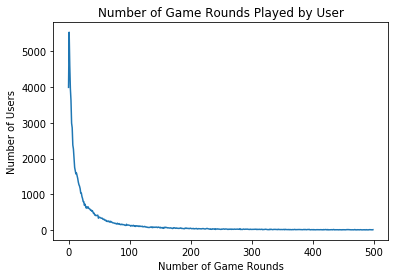

In [94]:
plot = cookie_cats.groupby("sum_gamerounds")["userid"].count().head(500)
plot.plot()
plt.title("Number of Game Rounds Played by User")
plt.xlabel('Number of Game Rounds')
plt.ylabel('Number of Users')
plt.show()

We can see that many users play a small number of levels, whereas there are only a few users who have played a large number of levels.

We can see that there does not seem to be any inconsistencies in our data, and looks to be well organized.

## Preparing the Data

We will prepare the data by creating contingency tables that will be used in our Chi-squared testing in the A/B testing portion of our analysis.  The test will be explained in the next section.

First we will create some tables that contain information about the retention rates at day one and seven for each version of the game.

In [73]:
Xtab_retention_1 = pd.crosstab(cookie_cats.version, cookie_cats.retention_1)
Xtab_retention_7 = pd.crosstab(cookie_cats.version, cookie_cats.retention_7)

In [71]:
Xtab_retention_1

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


In [72]:
Xtab_retention_7

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [83]:
percent_1_30 = 20034 / (20043 + 24666) *100
percent_1_40 = 20119 / (20119 + 25370) *100
percent_7_30 = 8502 / (8502 + 36198) *100
percent_7_40 = 8279 / (8279 + 37210) *100
print('Percent Retained (Day One, Gate at Level 30):', round(percent_1_30, 2))
print('Percent Retained (Day One, Gate at Level 40):', round(percent_1_40, 2))
print('Percent Retained (Day Seven, Gate at Level 30):', round(percent_7_30, 2))
print('Percent Retained (Day Seven, Gate at Level 40):', round(percent_7_40, 2))

Percent Retained (Day One, Gate at Level 30): 44.81
Percent Retained (Day One, Gate at Level 40): 44.23
Percent Retained (Day Seven, Gate at Level 30): 19.02
Percent Retained (Day Seven, Gate at Level 40): 18.2


These tables will be important for testing the relationship between retention and game version once we begin our A/B testing. We can also see that there is a slightly higher percentage of users retained given the gate at level 30.

Next we will make a table to see the relationship between the game version and the number of rounds played by a user.

In [64]:
Xtab_gamerounds = pd.crosstab(cookie_cats.version, cookie_cats.sum_gamerounds)

Then we will split the data by game version to see if there is any connection between day one retention and day seven retention, which we will use as a sanity check later in the analysis.

In [23]:
cookie_cats_30 = cookie_cats[cookie_cats.version == 'gate_30']
cookie_cats_30.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
6,1066,gate_30,0,False,False
11,2101,gate_30,0,False,False
13,2179,gate_30,39,True,False


In [24]:
cookie_cats_40 = cookie_cats[cookie_cats.version == 'gate_40']
cookie_cats_40.head()

,userid,version,sum_gamerounds,retention_1,retention_7
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
7,1444,gate_40,2,False,False


In [42]:
Xtab_30 = pd.crosstab(cookie_cats_30.retention_1, cookie_cats_30.retention_7)
Xtab_40 = pd.crosstab(cookie_cats_40.retention_1, cookie_cats_40.retention_7)

In [43]:
Xtab_30

retention_7,False,True
retention_1,,
False,22840,1826
True,13358,6676


In [41]:
Xtab_40

retention_7,False,True
retention_1,,
False,23597,1773
True,13613,6506


Now that we have made our contingency tables, it is time to test them.

## Performing A/B Testing

### Testing Method

The test that we will be using to determine signficance is the Chi-squared test of independence. The purpose of the Chi-squared test is to see whether two variables are most likely related or not. This test has four outputs, the Chi-squared value, the p-value, the degrees of freedom, and the expected values. In our analysis, we will look at the p-value. The p-value is caluclated by taking the difference between the observed value and a reference value.  A greater difference between these two values results in a lower p-value. The p-value indicates the likelihood that another sample of the same size would give the same result.  The lower the p-value, the more significant the result.

### Running the Tests

Since we will be running the same test multiple times, lets create a function that will run it for us. We will choose a significance threshold of 0.05. This means that we will consider the results significant if the p-value is 0.05 or lower.

First we will explore the relationship between game version and retention on days one and seven.

In [50]:
def chi2_test(contingency_table):
    chi2, pval, dof, expected = chi2_contingency(contingency_table)
    if pval <= 0.05:
        print("Significant")
    else:
        print("Not Significant")

In [66]:
print('Test Result for Day One Retention:')
chi2_test(Xtab_retention_1)

Test Result for Day One Retention:
Not Significant


In [67]:
print('Test Result for Day Seven Retention:')
chi2_test(Xtab_retention_7)

Test Result for Day Seven Retention:
Significant


So from our test, we can see that there is not a significant correlation between game version and retention on day one, but there is a signficiant correlation between game version and retention one week after installing Cookie Cats. While preparing the data, we saw that there were a higher number of retentions when there was a gate at level 30.

Lets check if there is a significance between game version and number of rounds played.

In [68]:
print('Test Result for Relationship Between Version and Number of Game Rounds:')
chi2_test(Xtab_gamerounds)

Test Result for Relationship Between Version and Number of Game Rounds:
Not Significant


We can see that there is not a signficant relationship between the version of game and number of game rounds played.

Let's check how retention on day one is related to retention on day seven for each version of the game as a sanity check.  We would expect that there would be a relationship between playing on the first day of downloading and the seventh day, so let's see if that is what we get.

In [69]:
print('Test Result for Day One to Day Seven Retention Given Gate at Level 30:')
chi2_test(Xtab_30)

Test Result for Day One to Day Seven Retention Given Gate at Level 30:
Significant


In [70]:
print('Test Result for Day One to Day Seven Retention Given Gate at Level 40:')
chi2_test(Xtab_40)

Test Result for Day One to Day Seven Retention Given Gate at Level 40:
Significant


We can see that there is a significant relationship between day one retention and day seven retention, which is what we expected.

## Conclusion

After performing the chi-squared tests on our data, we find that there is a significant relationship between the version of the game and the retention one week later.  Placing a gate at level 30 resulted in a higher retention rate on day seven.  There was not a significant relationship between game version and retention on day one. There was also not a signficiant relationship between the game version and the number of rounds played by a user. Because of the significance of retention on day seven, <b>it would be more benificial to have the gate at level 30 than level 40.</b>

## Sources

Sources on Chi-squared test and p-values:

__[Investopedia: p-value](https://www.investopedia.com/terms/p/p-value.asp)__

__[Chi-squared Test](https://www.jmp.com/en_us/statistics-knowledge-portal/chi-square-test/chi-square-test-of-independence.html)__